<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/02_ReadFlightlistCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to process either our own extracted flightlists, or excerpts of the data from "Crowdsourced air traffic data from The OpenSky Network 2020",
https://zenodo.org/records/7923702


In [ ]:
!pip install traffic

Include libraries

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
#from cartes.crs import Lambert93  # type: ignore

Always use python engine for dataframe queries, see
https://stackoverflow.com/questions/67063643/is-there-a-way-to-force-pandas-dataframe-query-to-use-python-as-default-engine

In [ ]:
from functools import partialmethod

pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")



Mount google drive to get the csv files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# where to save the data (and making shure that the directory exist)
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


List all the csv files in the folder.

In [ ]:
import glob

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
print(csv_files)

['/content/drive/My Drive/2024KomplexeNetze/Daten/2019-12-01_2020-01-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2024-01-01_2024-02-01.csv']


Testing with a single file for now....
Read into a pandas dataframe.

In [ ]:
flightdata = pd.read_csv(csv_files[0], parse_dates=["firstseen", "lastseen", "day"])

Quick check what we got from the file...

In [ ]:
flightdata.head()

,icao24,firstseen,departure,lastseen,arrival,callsign,day
0,3c0cdb,2019-12-01 09:00:09+00:00,EDDK,2019-12-01 10:04:13+00:00,EGLL,AYY162,2019-12-01 00:00:00+00:00
1,3c56f6,2019-12-01 18:04:39+00:00,EDDS,2019-12-01 18:51:22+00:00,LOWW,EWG62E,2019-12-01 00:00:00+00:00
2,3c56f6,2019-12-01 13:10:40+00:00,EDDS,2019-12-01 14:23:23+00:00,LIRF,EWG2RY,2019-12-01 00:00:00+00:00
3,3c56f6,2019-12-01 06:31:27+00:00,EDDS,2019-12-01 07:53:19+00:00,NaN,EWG35Z,2019-12-01 00:00:00+00:00
4,3c4d67,2019-12-01 18:10:02+00:00,EDDG,2019-12-01 18:42:53+00:00,EDDF,DLH3NJ,2019-12-01 00:00:00+00:00


In [ ]:
flightdata.describe()


,icao24,firstseen,departure,lastseen,arrival,callsign,day
count,115935,115833,103938,115935,106806,115894,115935
unique,6224,NaN,678,NaN,849,10718,NaN
top,3c6583,NaN,EDDF,NaN,EDDF,CHX86,NaN
freq,218,NaN,17119,NaN,17934,104,NaN
mean,NaN,2019-12-15 15:34:41.809363968+00:00,NaN,2019-12-15 17:49:13.079096320+00:00,NaN,NaN,2019-12-15 04:01:18.623366912+00:00
min,NaN,2019-11-30 04:33:10+00:00,NaN,2019-12-01 00:02:46+00:00,NaN,NaN,2019-12-01 00:00:00+00:00
25%,NaN,2019-12-08 08:36:00+00:00,NaN,2019-12-08 10:39:56+00:00,NaN,NaN,2019-12-08 00:00:00+00:00
50%,NaN,2019-12-15 11:35:37+00:00,NaN,2019-12-15 13:48:24+00:00,NaN,NaN,2019-12-15 00:00:00+00:00
75%,NaN,2019-12-22 13:52:36+00:00,NaN,2019-12-22 16:07:24.500000+00:00,NaN,NaN,2019-12-22 00:00:00+00:00
max,NaN,2019-12-31 22:36:02+00:00,NaN,2019-12-31 23:55:59+00:00,NaN,NaN,2019-12-31 00:00:00+00:00


Check for empty fileds in the data - there seem to be a few...

In [ ]:
nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
print(nan_percentage)

icao24        0.000000
firstseen     0.087980
departure    10.348040
lastseen      0.000000
arrival       7.874240
callsign      0.035365
day           0.000000
dtype: float64


Should we drop this data? Spend more time figuring out where it comes from? (e.g. if there is another entry with the same callsign and time, but complete)

----


In [ ]:
from traffic.data import airports
import altair as alt

Add city names to the airports

In [ ]:
flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
flightdata = flightdata.rename(columns={"municipality": "departure_city"})
flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
flightdata = flightdata.rename(columns={"municipality": "arrival_city"})
flightdata.tail()


,icao24,firstseen,departure,lastseen,arrival,callsign,day,icao_x,departure_city,icao_y,arrival_city
115930,407536,2019-12-31 17:37:45+00:00,EGLL,2019-12-31 18:28:19+00:00,EDDL,BAW932,2019-12-31 00:00:00+00:00,EGLL,London,EDDL,Düsseldorf
115931,3c65c1,2019-12-31 14:07:52+00:00,EDDT,2019-12-31 15:04:45+00:00,EDDF,DLH5CK,2019-12-31 00:00:00+00:00,EDDT,Berlin,EDDF,Frankfurt am Main
115932,3c66e2,2019-12-31 12:01:37+00:00,NaN,2019-12-31 13:28:13+00:00,EDDM,DLH5TN,2019-12-31 00:00:00+00:00,NaN,NaN,EDDM,Munich
115933,4b1a65,2019-12-31 17:16:19+00:00,LSGG,2019-12-31 18:40:24+00:00,EDDH,EZS85BF,2019-12-31 00:00:00+00:00,LSGG,Geneva,EDDH,Hamburg
115934,4bcde3,2019-12-31 08:28:17+00:00,NaN,2019-12-31 11:25:27+00:00,EDDS,SXS4WK,2019-12-31 00:00:00+00:00,NaN,NaN,EDDS,Stuttgart


Now we can do other things with the data, like look at number of departures per day from certain airports.

In [ ]:
departure_per_day=flightdata.query(f'departure == "EDDH"').groupby("day").agg(dict(callsign="count"))

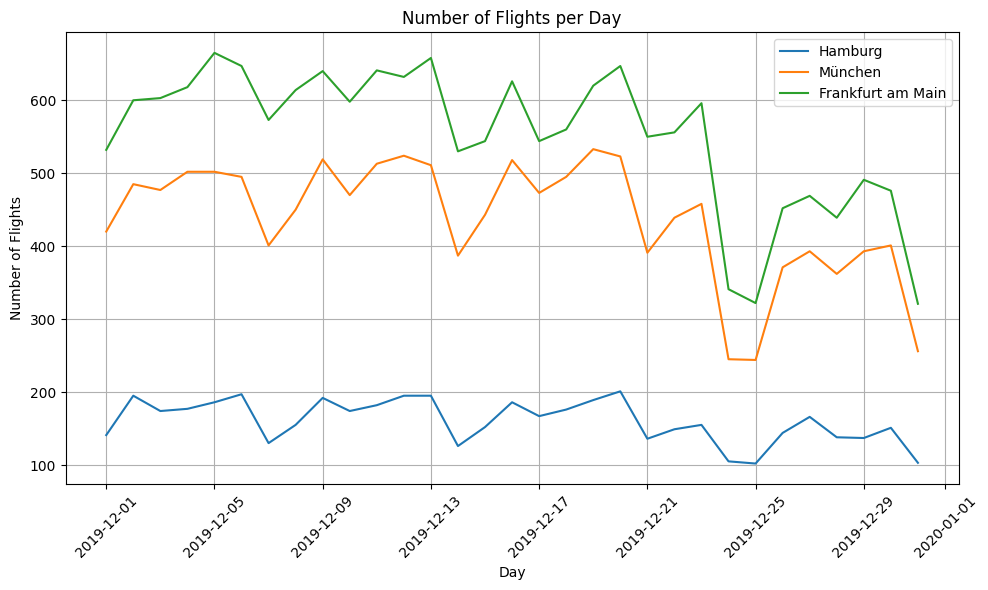

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting EDDFS
departure_per_day_H = flightdata.query(f'departure_city == "Hamburg"').groupby("day").agg(dict(callsign="count"))
plt.plot(departure_per_day_H.index, departure_per_day_H['callsign'], label='Hamburg')

# Plotting EDDM
departure_per_day_M = flightdata.query(f'departure_city == "Munich"').groupby("day").agg(dict(callsign="count"))
plt.plot(departure_per_day_M.index, departure_per_day_M['callsign'], label='München')

# Plotting EDDH
departure_per_day_F = flightdata.query(f'departure_city == "Frankfurt am Main"').groupby("day").agg(dict(callsign="count"))
plt.plot(departure_per_day_F.index, departure_per_day_F['callsign'], label='Frankfurt am Main')


# Customize the plot
plt.xlabel("Day")
plt.ylabel("Number of Flights")
plt.title("Number of Flights per Day")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()